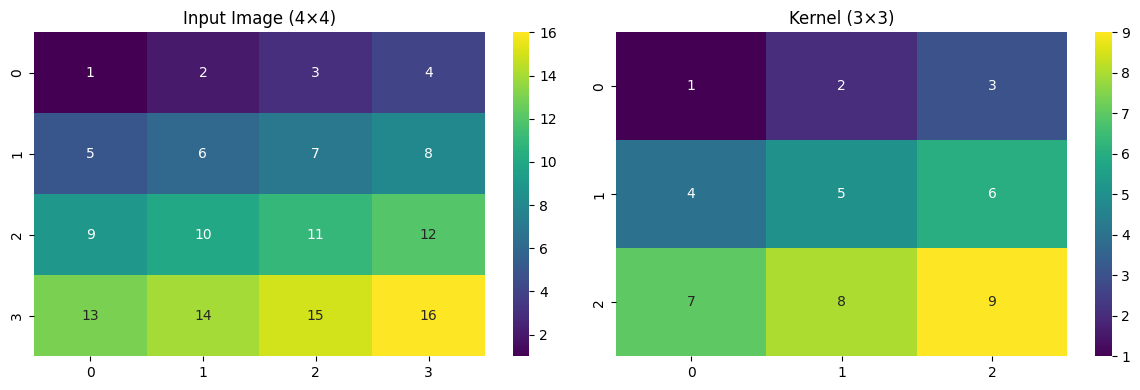


Output position (0,0):
Input patch:
tensor([[ 1.,  2.,  3.],
        [ 5.,  6.,  7.],
        [ 9., 10., 11.]])

Kernel:
tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Element-wise multiplication:
tensor([[ 1.,  4.,  9.],
        [20., 30., 42.],
        [63., 80., 99.]])
Sum (output value): 348.0

Output position (0,1):
Input patch:
tensor([[ 2.,  3.,  4.],
        [ 6.,  7.,  8.],
        [10., 11., 12.]])

Kernel:
tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Element-wise multiplication:
tensor([[  2.,   6.,  12.],
        [ 24.,  35.,  48.],
        [ 70.,  88., 108.]])
Sum (output value): 393.0

Output position (1,0):
Input patch:
tensor([[ 5.,  6.,  7.],
        [ 9., 10., 11.],
        [13., 14., 15.]])

Kernel:
tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Element-wise multiplication:
tensor([[  5.,  12.,  21.],
        [ 36.,  50.,  66.],
        [ 91., 112., 135.]])
Sum (output value): 528.0

Output position (1

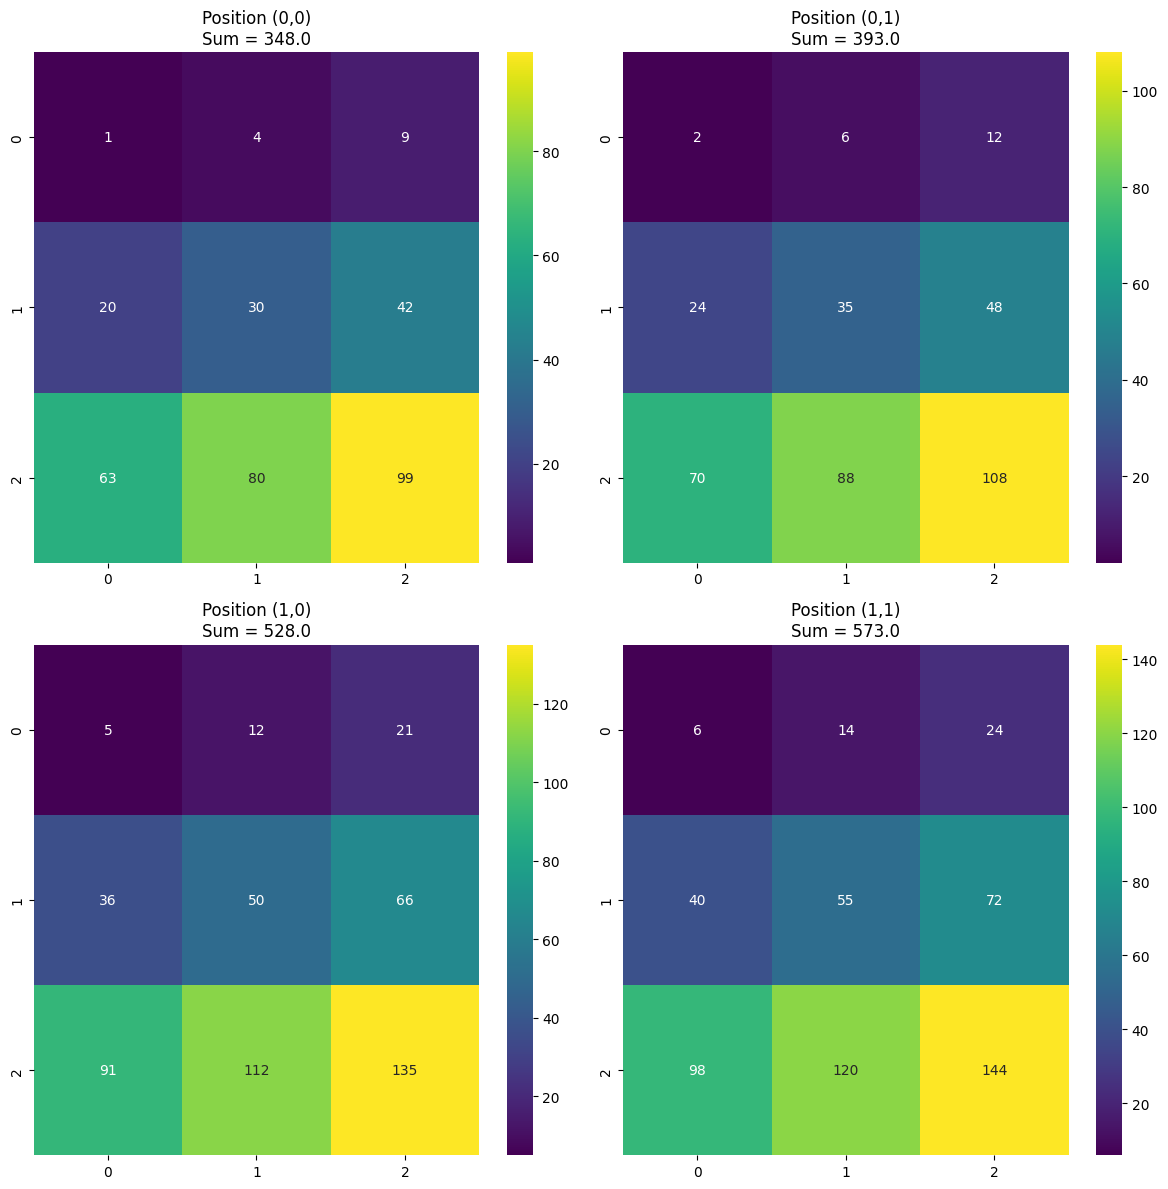

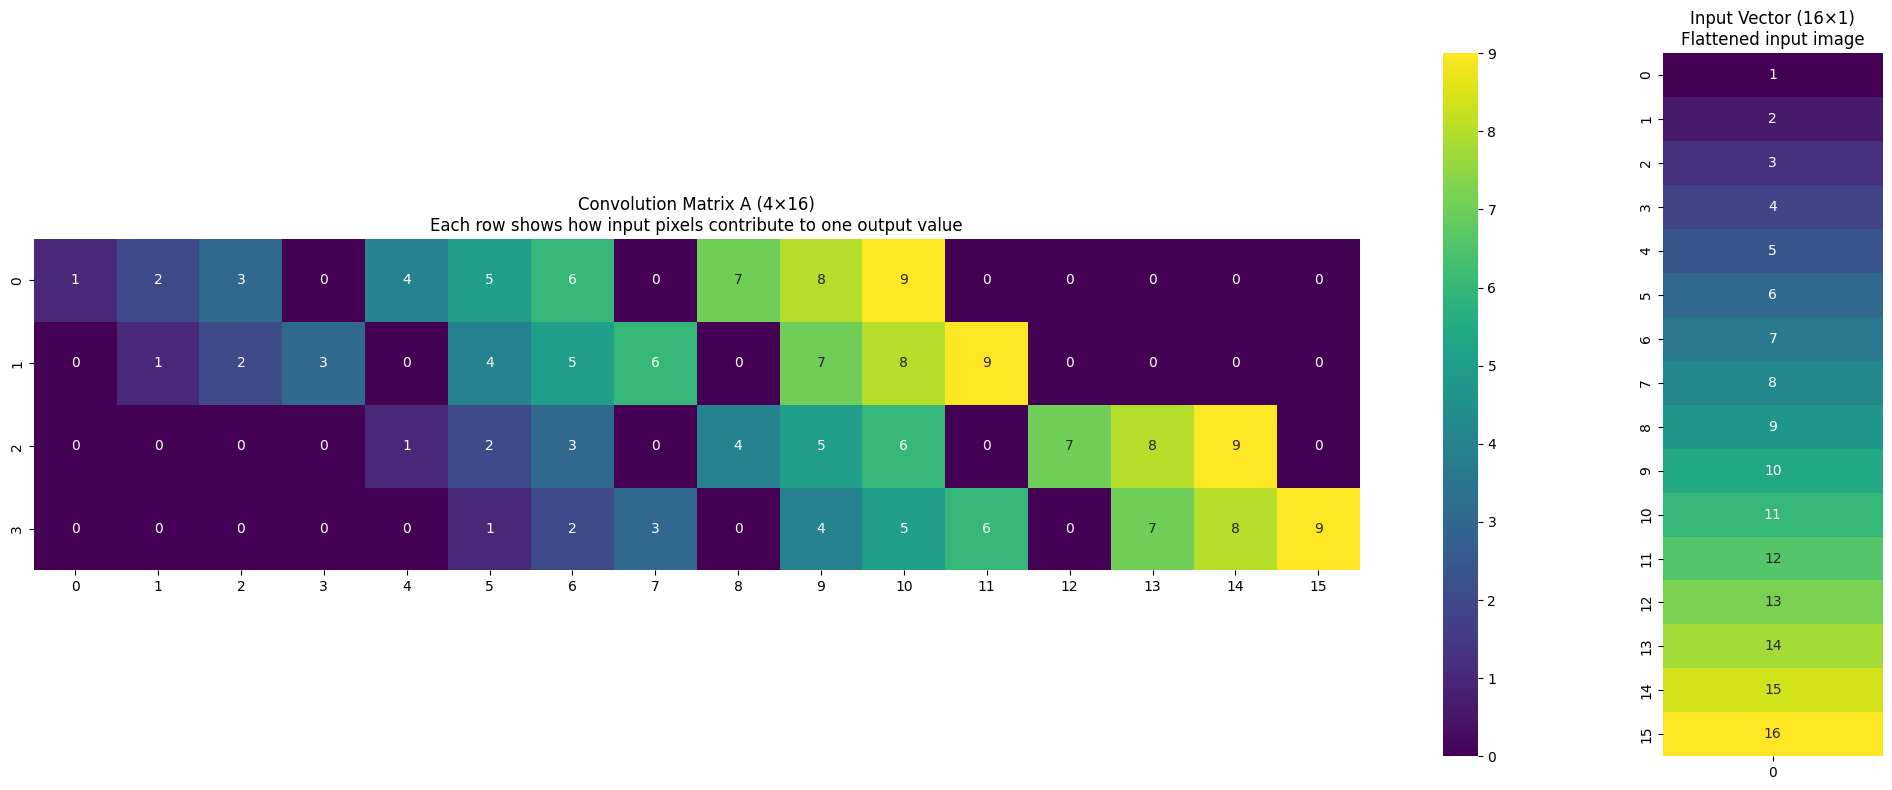

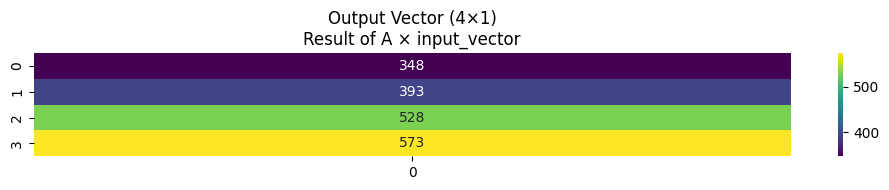

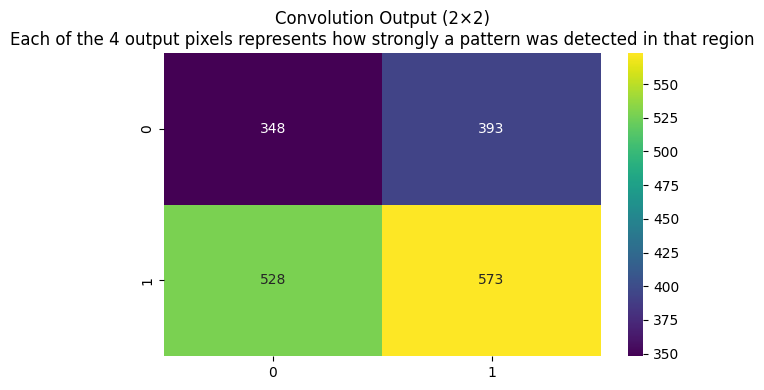

In [67]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------------
# 1) "Image"  (4 × 4)   and   Kernel  (3 × 3)
# This is a 4x4 input image tensor where values increase sequentially from 1 to 16
# Each number represents a pixel intensity value in the input image
# The values increase from top-left (1) to bottom-right (16)
v_img = torch.tensor([[1,  2,  3,  4],
                      [5,  6,  7,  8],
                      [9, 10, 11, 12],
                      [13,14, 15, 16]], dtype=torch.float32)

# This kernel represents a 3x3 filter where values increase from 1 to 9
# Each number represents a weight that will be multiplied with corresponding input pixels
# The pattern shows increasing values from top-left (1) to bottom-right (9)
kernel = torch.tensor([[1, 2, 3],
                       [4, 5, 6],
                       [7, 8, 9]], dtype=torch.float32)

# Visualize input image and kernel
plt.figure(figsize=(12, 4))
plt.subplot(121)
sns.heatmap(v_img.numpy(), annot=True, cmap='viridis', fmt='.0f')
plt.title('Input Image (4×4)')
plt.subplot(122)
sns.heatmap(kernel.numpy(), annot=True, cmap='viridis', fmt='.0f')
plt.title('Kernel (3×3)')
plt.tight_layout()
plt.show()

# Reshape input image to (batch, channels, height, width) format
# Reshape kernel to (out_channels, in_channels, height, width) format
# out_channels: number of filters/kernels (1 in this case)
# in_channels: number of input channels (1 in this case since it's grayscale)
v_bchw = v_img.unsqueeze(0).unsqueeze(0)      # (1,1,4,4)
w_oihw = kernel.unsqueeze(0).unsqueeze(0)     # (1,1,3,3)

# Print and visualize the multiplications for each output position
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, (i, j) in enumerate([(0,0), (0,1), (1,0), (1,1)]):
    # Get the 3x3 patch of input image
    patch = v_img[i:i+3, j:j+3]
    
    # Print the multiplication
    print(f"\nOutput position ({i},{j}):")
    print("Input patch:")
    print(patch)
    print("\nKernel:")
    print(kernel)
    print("\nElement-wise multiplication:")
    mult = patch * kernel
    print(mult)
    print(f"Sum (output value): {torch.sum(mult)}")
    
    # Visualize the multiplication
    ax = axes[idx]
    sns.heatmap(mult.numpy(), annot=True, cmap='viridis', fmt='.0f', ax=ax)
    ax.set_title(f'Position ({i},{j})\nSum = {torch.sum(mult)}')

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 2) Build the explicit convolution matrix A  (4 × 16)
H, W = 4, 4          # Input image dimensions
out_h, out_w = 2, 2  # Output dimensions after convolution
A = torch.zeros(out_h * out_w, H * W)  # Create empty matrix (4×16)

# For each input pixel position p:
for p in range(H * W):
    delta = torch.zeros((1, 1, 4, 4))  # Explicit shape (batch, channel, height, width)
    # Convert 1D index p into 2D (row, column) coordinates by:
    # - row = p // W (integer division)
    # - col = p % W (modulo)
    r, c = divmod(p, W)
    delta[0, 0, r, c] = 1.0  # Set the single 1.0 at position (r,c)
    # This line computes how a single input pixel (at position p) contributes to all output values
    # 1. delta is a 4x4 matrix with a single 1.0 at position p
    # 2. F.conv2d applies the kernel w_oihw to this single-pixel input
    # 3. The result is flattened and stored in column p of matrix A
    # This builds one column of the convolution matrix A, showing how one input pixel affects all outputs
    conv_result = F.conv2d(delta, w_oihw).flatten()
    # print(f"Column {p}: Storing convolution result for input pixel at position ({r},{c})")
    # print(f"Convolution result: {conv_result}")
    A[:, p] = conv_result
# Visualize convolution matrix A and input vector side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'width_ratios': [4, 1]})

# Plot convolution matrix A
sns.heatmap(A.numpy(), annot=True, cmap='viridis', fmt='.0f', ax=ax1, square=True)
ax1.set_title('Convolution Matrix A (4×16)\nEach row shows how input pixels contribute to one output value', fontsize=12)
ax1.set_aspect('equal')  # Force square cells

# Plot input vector as a column vector
v_flat = v_img.flatten()  # Flatten input image to vector
sns.heatmap(v_flat.reshape(-1, 1), annot=True, cmap='viridis', fmt='.0f', ax=ax2, cbar=False)
ax2.set_title('Input Vector (16×1)\nFlattened input image', fontsize=12)
ax2.set_aspect(0.2)  # Make the input vector visualization narrower

plt.tight_layout()
plt.show()

# Visualize the matrix multiplication result
y_from_A = A @ v_flat  # Matrix multiplication
plt.figure(figsize=(10, 2))
sns.heatmap(y_from_A.reshape(-1, 1), annot=True, cmap='viridis', fmt='.0f')
plt.title('Output Vector (4×1)\nResult of A × input_vector')
plt.tight_layout()
plt.show()

y_from_A = A @ v_flat     # Matrix multiplication
y_torch = F.conv2d(v_bchw, w_oihw, stride=1, padding=0)  # (1,1,2,2)
assert torch.allclose(y_from_A, y_torch.flatten())  # Should match direct convolution result

# Visualize the 2x2 output matrix from the convolution operation
# Each value represents the result of applying the 3x3 kernel to a 3x3 patch of the input image
plt.figure(figsize=(6, 4))
sns.heatmap(y_torch.squeeze().numpy(), annot=True, cmap='viridis', fmt='.0f')
plt.title('Convolution Output (2×2)\nEach of the 4 output pixels represents how strongly a pattern was detected in that region')
plt.tight_layout()
plt.show()

# What the model is trying to accomplish
# 
# Spatial Downsampling
# Going from 4×4 input → 2×2 output reduces spatial dimensions while preserving important features:
# Input: 16 pixels of raw data
# Output: 4 values of processed features
# More compact representation with learned features
#
# Local Pattern Recognition
# Each output pixel "summarizes" what the kernel detected in its receptive field:
# The kernel slides across the input
# Each position produces one output value
# Higher values = stronger pattern match
#
# For our toy example with a Bottom-Right heavy kernel:
# If the 3×3 kernel has its highest weights in the bottom-right, then this convolution is specifically looking for input regions where:
# The bottom-right pixels are bright/high values
# The pattern matches the kernel's weight distribution
# Each output pixel answers: "How much does this region of the input match my bottom-right-heavy pattern?"

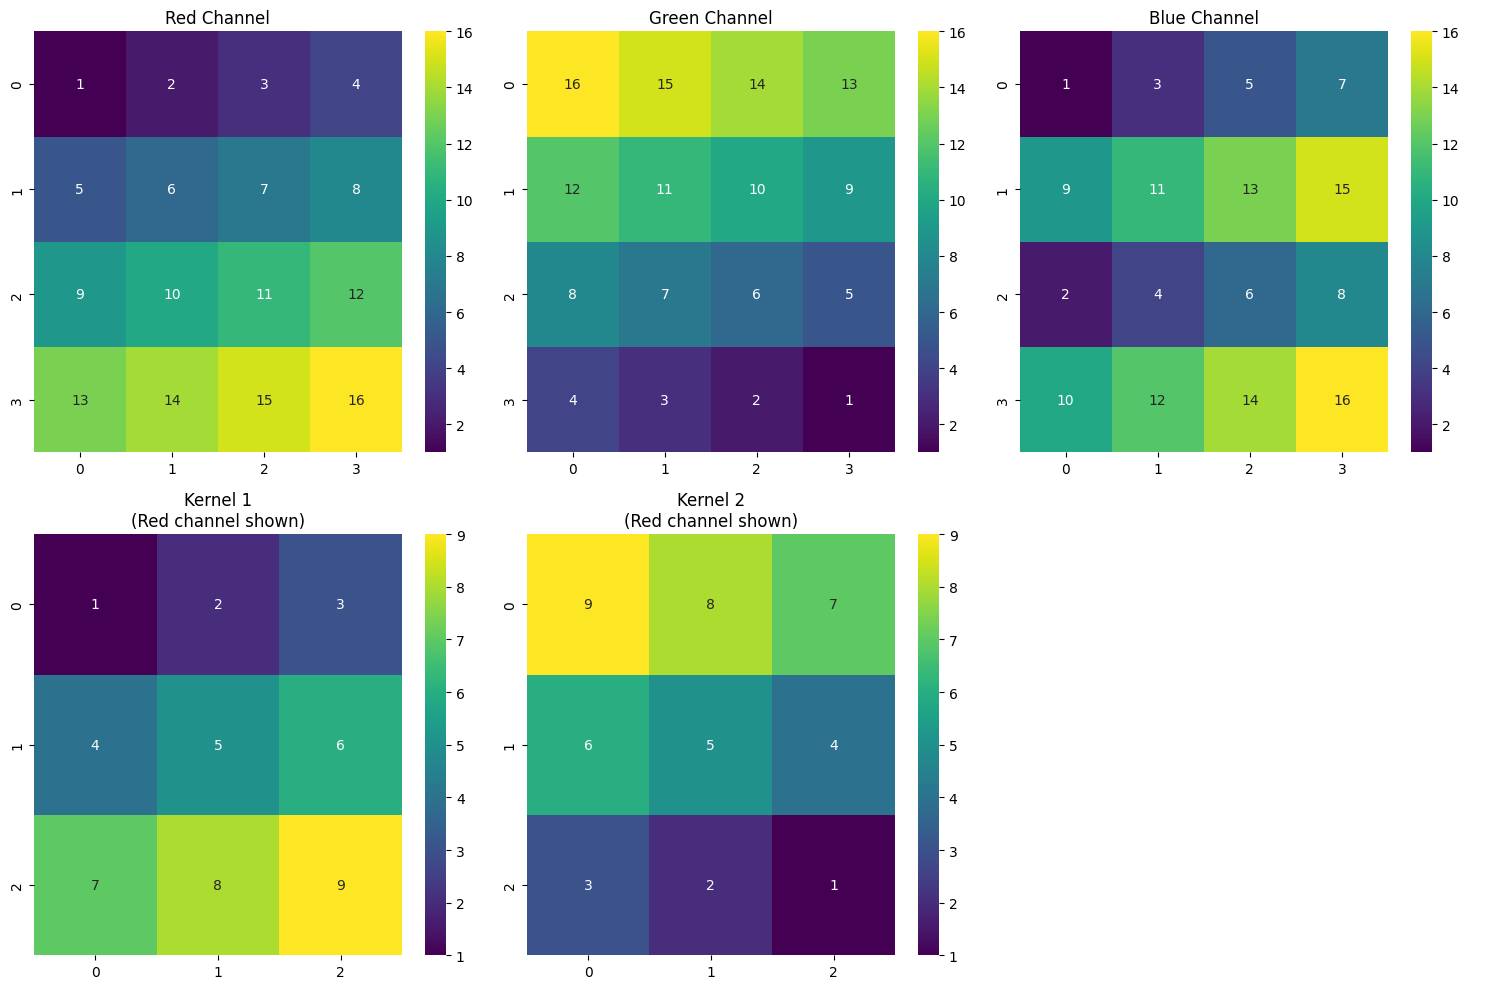

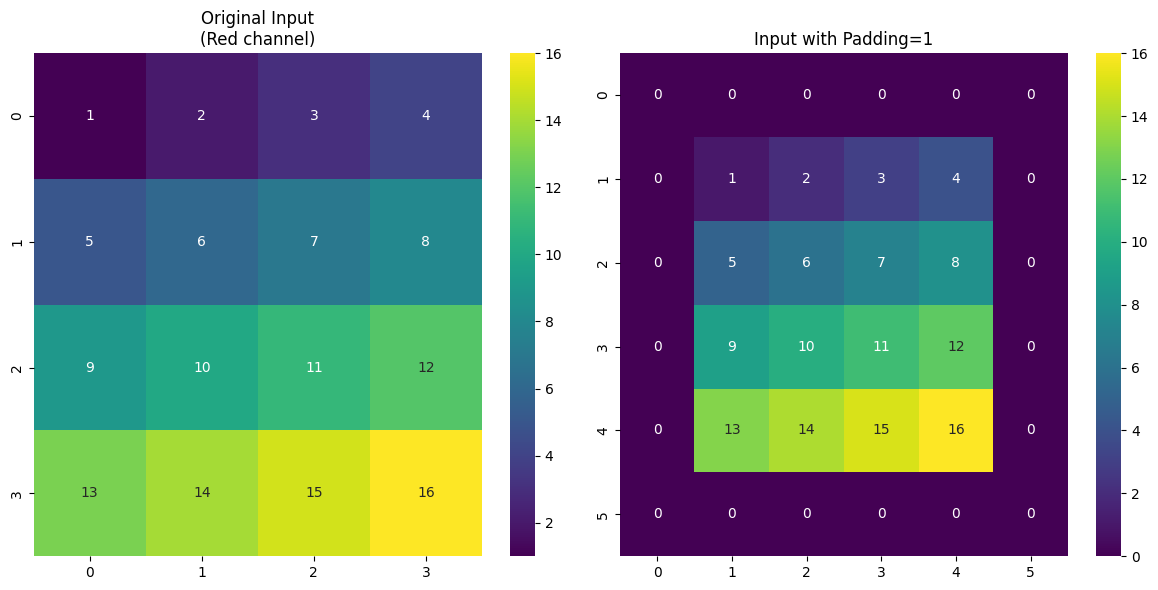

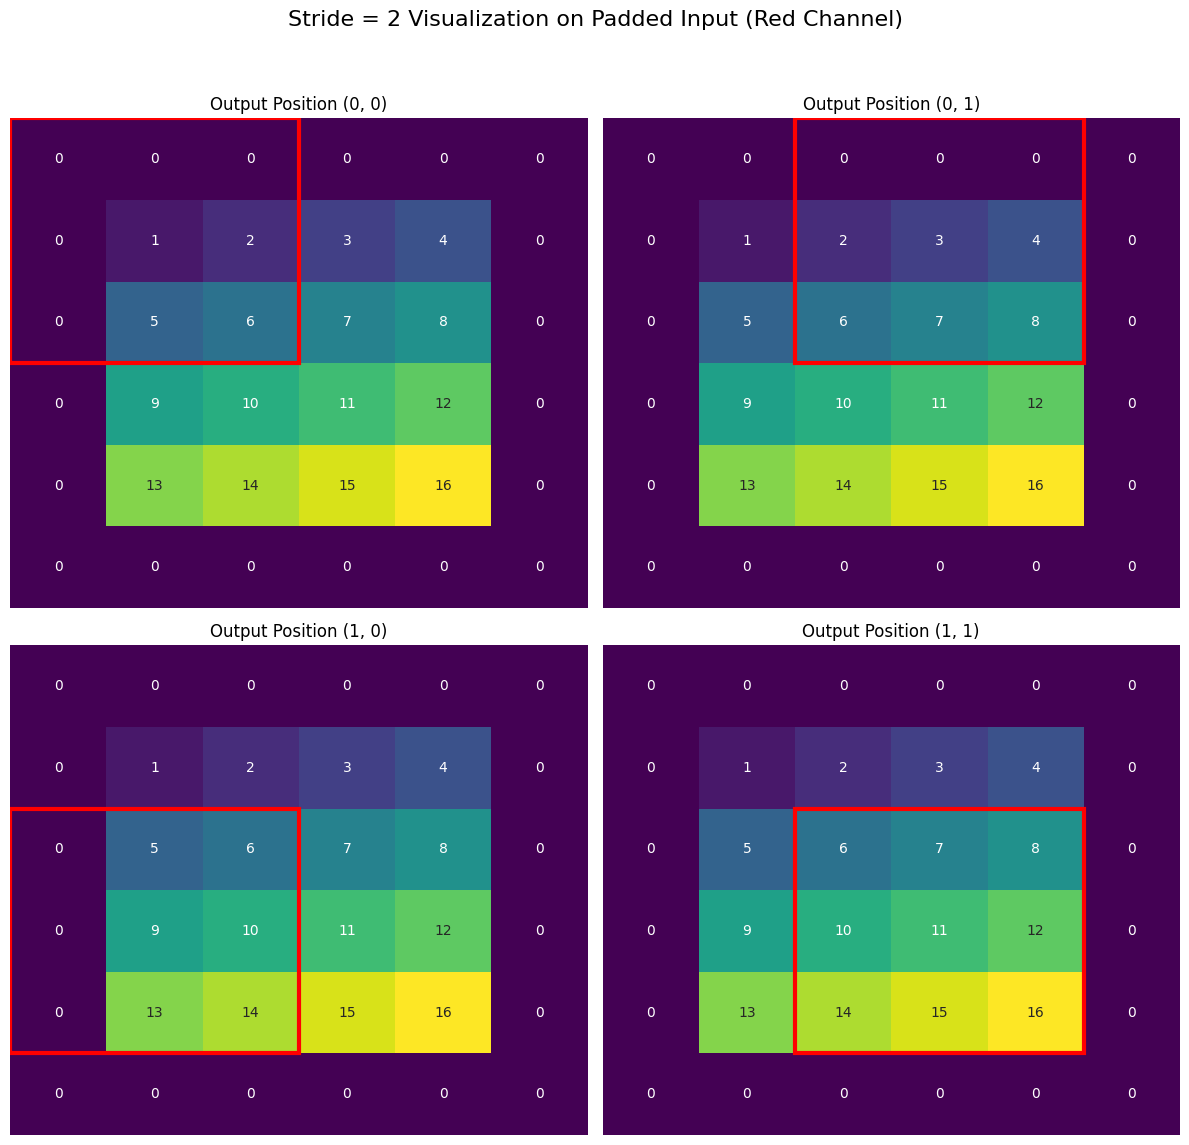


Detailed Convolution Calculations for All Feature Maps:


==================== Calculating Feature Map 1 ====================
Using Kernel 1 (shape: torch.Size([3, 3, 3]))

Output Position (0, 0):

--- Input Channel 0 ---
Input Region:
[[0. 0. 0.]
 [0. 1. 2.]
 [0. 5. 6.]]

Kernel Slice (for input channel 0):
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]

Element-wise Multiplication:
[[ 0.  0.  0.]
 [ 0.  5. 12.]
 [ 0. 40. 54.]]

Channel Sum: 111.0

--- Input Channel 1 ---
Input Region:
[[ 0.  0.  0.]
 [ 0. 16. 15.]
 [ 0. 12. 11.]]

Kernel Slice (for input channel 1):
[[9. 8. 7.]
 [6. 5. 4.]
 [3. 2. 1.]]

Element-wise Multiplication:
[[ 0.  0.  0.]
 [ 0. 80. 60.]
 [ 0. 24. 11.]]

Channel Sum: 175.0

--- Input Channel 2 ---
Input Region:
[[ 0.  0.  0.]
 [ 0.  1.  3.]
 [ 0.  9. 11.]]

Kernel Slice (for input channel 2):
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]

Element-wise Multiplication:
[[ 0.  0.  0.]
 [ 0.  1.  3.]
 [ 0.  9. 11.]]

Channel Sum: 24.0

>>> Final value at Output Position (0, 0) for 

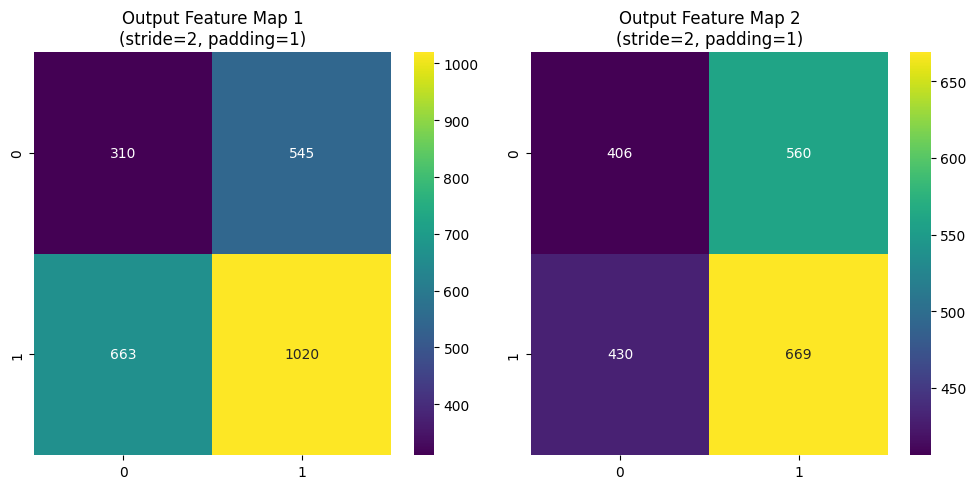


Convolution Details:
Input shape: torch.Size([1, 3, 4, 4])
Kernels shape: torch.Size([2, 3, 3, 3])
Output shape: torch.Size([1, 2, 2, 2])
Stride: 2
Padding: 1
y_torch:  tensor([ 310.,  545.,  663., 1020.,  406.,  560.,  430.,  669.])


In [69]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------------
# 1) Multi-channel input image (4×4×3) and multiple kernels (2×3×3×3)
# Create a 4x4 RGB image with 3 channels
v_img = torch.stack([
    torch.tensor([[1,  2,  3,  4],    # Red channel
                 [5,  6,  7,  8],
                 [9, 10, 11, 12],
                 [13,14, 15, 16]], dtype=torch.float32),
    torch.tensor([[16,15,14,13],      # Green channel
                 [12,11,10, 9],
                 [8,  7,  6,  5],
                 [4,  3,  2,  1]], dtype=torch.float32),
    torch.tensor([[1,  3,  5,  7],    # Blue channel
                 [9, 11,13,15],
                 [2,  4,  6,  8],
                 [10,12,14,16]], dtype=torch.float32)
])

# Create two different 3x3 kernels for each input channel
kernel1 = torch.stack([
    torch.tensor([[1, 2, 3],           # Kernel 1 for Red channel
                 [4, 5, 6],
                 [7, 8, 9]], dtype=torch.float32),
    torch.tensor([[9, 8, 7],           # Kernel 1 for Green channel
                 [6, 5, 4],
                 [3, 2, 1]], dtype=torch.float32),
    torch.tensor([[1, 1, 1],           # Kernel 1 for Blue channel
                 [1, 1, 1],
                 [1, 1, 1]], dtype=torch.float32)
])

kernel2 = torch.stack([
    torch.tensor([[9, 8, 7],           # Kernel 2 for Red channel
                 [6, 5, 4],
                 [3, 2, 1]], dtype=torch.float32),
    torch.tensor([[1, 2, 3],           # Kernel 2 for Green channel
                 [4, 5, 6],
                 [7, 8, 9]], dtype=torch.float32),
    torch.tensor([[1, 0, 1],           # Kernel 2 for Blue channel
                 [0, 1, 0],
                 [1, 0, 1]], dtype=torch.float32)
])

# Visualize input channels and kernels
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, (ax, title) in enumerate(zip(axes[0], ['Red Channel', 'Green Channel', 'Blue Channel'])):
    sns.heatmap(v_img[i].numpy(), annot=True, cmap='viridis', fmt='.0f', ax=ax)
    ax.set_title(title)

for i, (ax, title) in enumerate(zip(axes[1], ['Kernel 1', 'Kernel 2', ''])):
    if i < 2:
        # Show first channel of each kernel as example
        sns.heatmap(kernel1[0].numpy() if i == 0 else kernel2[0].numpy(), 
                   annot=True, cmap='viridis', fmt='.0f', ax=ax)
        ax.set_title(f'{title}\n(Red channel shown)')
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

# Reshape for convolution
v_bchw = v_img.unsqueeze(0)                    # Add batch dimension (1,3,4,4)
w_oihw = torch.stack([kernel1, kernel2])       # (2,3,3,3)

# Configure convolution parameters
stride = 2
padding = 1
# Visualize padding
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original input
sns.heatmap(v_img[0].numpy(), annot=True, cmap='viridis', fmt='.0f', ax=axes[0])
axes[0].set_title('Original Input\n(Red channel)')

# Input with padding
padded = F.pad(v_img[0].unsqueeze(0).unsqueeze(0), (padding, padding, padding, padding), mode='constant', value=0)
sns.heatmap(padded[0,0].numpy(), annot=True, cmap='viridis', fmt='.0f', ax=axes[1])
axes[1].set_title(f'Input with Padding={padding}')

plt.tight_layout()
plt.show()

# Visualize stride effect
# The output size is (H_out, W_out) where:
# H_out = floor((H_in + 2*padding - H_kernel) / stride) + 1
# W_out = floor((W_in + 2*padding - W_kernel) / stride) + 1
# For our example:
# H_out = floor((4 + 2*1 - 3) / 2) + 1 = floor(3/2) + 1 = 1 + 1 = 2
# W_out = floor((4 + 2*1 - 3) / 2) + 1 = floor(3/2) + 1 = 1 + 1 = 2
# The output will be 2x2. Let's visualize the 4 positions the kernel is applied to.

output_h = ((v_img.shape[1] + 2 * padding - kernel1.shape[1]) // stride) + 1
output_w = ((v_img.shape[2] + 2 * padding - kernel1.shape[2]) // stride) + 1

fig, axes = plt.subplots(output_h, output_w, figsize=(12, 12))
# Use the same padded input from the previous visualization
padded_input = F.pad(v_img[0], (padding, padding, padding, padding), 'constant', 0)

for i in range(output_h):
    for j in range(output_w):
        ax = axes[i, j]
        sns.heatmap(padded_input.numpy(), annot=True, cmap='viridis', fmt='.0f', ax=ax, cbar=False)
        
        # Calculate top-left corner of the kernel application based on stride
        start_row = i * stride
        start_col = j * stride
        
        # Draw a rectangle to highlight the kernel's position
        rect = plt.Rectangle((start_col, start_row), kernel1.shape[2], kernel1.shape[1], 
                             linewidth=3, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        
        ax.set_title(f'Output Position ({i}, {j})')
        ax.set_xticks([])
        ax.set_yticks([])

plt.suptitle(f'Stride = {stride} Visualization on Padded Input (Red Channel)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

# Calculate and visualize each multiplication for all feature maps
print("\nDetailed Convolution Calculations for All Feature Maps:")

# Pad the input image across all channels
padded_v_img = F.pad(v_img, (padding, padding, padding, padding), mode='constant', value=0)
padded_input_numpy = padded_v_img.numpy()

# Get dimensions from the weight tensor
num_output_channels = w_oihw.shape[0] # gives the number of output channels (i.e., the number of kernels/filters).
num_input_channels = w_oihw.shape[1] # gives the number of input channels (i.e., the number of channels in the input image).
kernel_h, kernel_w = w_oihw.shape[2], w_oihw.shape[3] # gives the height and width of the kernel/filter.

# Iterate over each kernel to calculate each output feature map
for k in range(num_output_channels):
    kernel = w_oihw[k]  # This kernel has shape (C_in, K_h, K_w)
    kernel_numpy = kernel.numpy()
    
    print(f"\n\n{'='*20} Calculating Feature Map {k+1} {'='*20}")
    print(f"Using Kernel {k+1} (shape: {kernel.shape})")

    # For each position in the output feature map
    for i in range(output_h):
        for j in range(output_w):
            print(f"\nOutput Position ({i}, {j}):")
            
            # Calculate the region of interest
            start_row = i * stride
            end_row = start_row + kernel_h
            start_col = j * stride
            end_col = start_col + kernel_w
            
            # Process each input channel against the corresponding kernel slice
            channel_sums = []
            for c in range(num_input_channels):
                print(f"\n--- Input Channel {c} ---")
                
                # Get region for this channel from the padded input
                region = padded_input_numpy[c, start_row:end_row, start_col:end_col]
                
                # Get the corresponding slice from the current kernel
                kernel_slice = kernel_numpy[c]
                
                print("Input Region:")
                print(region)
                
                print(f"\nKernel Slice (for input channel {c}):")
                print(kernel_slice)
                
                # Calculate and print the element-wise multiplication
                mult = region * kernel_slice
                print("\nElement-wise Multiplication:")
                print(mult)
                
                # Store the sum for this channel
                channel_sum = np.sum(mult)
                channel_sums.append(channel_sum)
                print(f"\nChannel Sum: {channel_sum}")
            
            # The final output value is the sum of results from all channels
            final_value = sum(channel_sums)
            print(f"\n>>> Final value at Output Position ({i}, {j}) for Feature Map {k+1}: {final_value}")
            print("-" * 50)

# Perform convolution
y_torch = F.conv2d(v_bchw, w_oihw, stride=stride, padding=padding)  # (1,2,2,2)

# Visualize output feature maps
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, ax in enumerate(axes):
    sns.heatmap(y_torch[0,i].numpy(), annot=True, cmap='viridis', fmt='.0f', ax=ax)
    ax.set_title(f'Output Feature Map {i+1}\n(stride={stride}, padding={padding})')
plt.tight_layout()
plt.show()

# Print convolution details
print(f"\nConvolution Details:")
print(f"Input shape: {v_bchw.shape}")
print(f"Kernels shape: {w_oihw.shape}")
print(f"Output shape: {y_torch.shape}")
print(f"Stride: {stride}")
print(f"Padding: {padding}")
print("y_torch: ", y_torch.flatten())

# What the model is trying to accomplish
# 
# Multi-channel Processing
# - Each kernel processes all input channels
# - Different kernels learn different features
# - Output channels represent different detected patterns
#
# Stride and Padding Effects
# - Stride > 1: Reduces spatial dimensions more aggressively
# - Padding > 0: Preserves spatial dimensions at edges
# - Output size = ((H + 2P - K) // S + 1, (W + 2P - K) // S + 1)
#   Example output size = ((4 + 2*1 - 3) // 2 + 1, (4 + 2*1 - 3) // 2 + 1) = (2, 2)
#   where H=4 (input height), W=4 (input width), P=1 (padding), K=3 (kernel size), S=2 (stride)
#
# Feature Learning
# - Each kernel learns to detect specific patterns
# - Multiple kernels allow detection of different features
# - Output channels can be thought of as different "views" of the input